## **ECOM90025 ADA Tutorial 9** ##

In [ ]:
# library packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import patsy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
from sklearn.linear_model import LassoCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error
import requests
from PIL import Image
from io import BytesIO

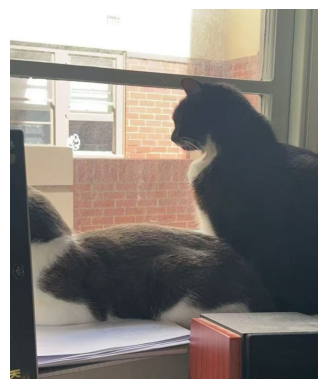

In [ ]:
# New cat!!
# https://drive.google.com/file/d/1_hO4oAGo8AERfvVG-9fPB2P2Wp3iWe2Z/view?usp=drive_link
url = 'https://drive.google.com/uc?id=1_hO4oAGo8AERfvVG-9fPB2P2Wp3iWe2Z'

# Download and open the image
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# my state this week with 2 mid exams
# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

###**Partial Least Square (PLS)**

### Partial Least Squares (PLS) — Algorithm (Don't need to know)
---


#### 1) Choose number of components $K$
- Pick $K$ via cross-validation (e.g., K-fold or LOOCV/PRESS).
- Typically $K \ll p$.

---

#### 2) Iterate over components $k=1,\dots,K$

**Inputs at step $k$:** current $X^{(k)}$ and $y^{(k)}$.  
(Initially $X^{(1)}=X$, $y^{(1)}=y$.)

#### 2.1 Weights and score
Find a weight vector $w_k$ such that the score $t_k = X^{(k)} w_k$ maximizes covariance with $y^{(k)}$:
$$
w_k \;\approx\; \arg\max_{\lVert w\rVert=1}\ \mathrm{Cov}\!\big(X^{(k)}w,\; y^{(k)}\big)^2.
$$
Form the score:
$$
t_k \;=\; X^{(k)} w_k \;\in\; \mathbb{R}^{n}.
$$

#### 2.2 Project (compute loadings)
Regress **each column** of $X^{(k)}$ on $t_k$ to get X-loadings $p_k$, and regress $y^{(k)}$ on $t_k$ to get Y-loading $c_k$:
Fitted (rank-1) parts:
$$
\widehat X_k = t_k p_k^\top,\qquad \widehat y_k = t_k c_k.
$$

#### 2.3 Deflate
Remove what this component explains:
$$
X^{(k+1)} = X^{(k)} - \widehat X_k = X^{(k)} - t_k p_k^\top,\qquad
y^{(k+1)} = y^{(k)} - \widehat y_k = y^{(k)} - t_k c_k.
$$

**Save/stack:**  
$W=[w_1,\dots,w_K]$, $T=[t_1,\dots,t_K]$, $P=[p_1,\dots,p_K]$, $q=[c_1,\dots,c_K]^\top$.

---

#### 3) Regress $y$ on the $K$ scores (low-dimensional OLS)
Do one OLS in score space:
$$
\hat q = (T^\top T)^{-1} T^\top y \in \mathbb{R}^{K}.
$$
Predictions in score space:
$$
\hat y = T \hat q.
$$

---

#### 4) Map back to original features (recover $\hat\beta$)
PLS regression coefficients on the original $X$:
$$
\boxed{\ \hat\beta = W\,(P^\top W)^{-1}\,\hat q \ } \quad (\in \mathbb{R}^{p}).
$$



In [ ]:
# load in data set
gas = pd.read_csv("https://www.dropbox.com/s/255h2nr3u82fj6j/gasoline.csv?dl=1")
octane = gas.iloc[:, 0]
nir= gas.iloc[:, 1:]

gas.head(4)
# y variable octane: value of fuel quality, that measures its resistence to engine knock
# x variable chemical properties: the fuel's absorbance to different spectrums of light
# perfect data for dimension reduction, because it has such a long x list

,octane,900 nm,902 nm,904 nm,906 nm,908 nm,910 nm,912 nm,914 nm,916 nm,...,1682 nm,1684 nm,1686 nm,1688 nm,1690 nm,1692 nm,1694 nm,1696 nm,1698 nm,1700 nm
0,85.30,-0.050193,-0.045903,-0.042187,-0.037177,-0.033348,-0.031207,-0.030036,-0.031298,-0.034217,...,1.198461,1.224243,1.242645,1.250789,1.246626,1.250985,1.264189,1.244678,1.245913,1.221135
1,85.25,-0.044227,-0.039602,-0.035673,-0.030911,-0.026675,-0.023871,-0.022571,-0.025410,-0.028960,...,1.128877,1.148342,1.189116,1.223242,1.253306,1.282889,1.215065,1.225211,1.227985,1.198851
2,88.45,-0.046867,-0.041260,-0.036979,-0.031458,-0.026520,-0.023346,-0.021392,-0.024993,-0.029309,...,1.147964,1.167798,1.198287,1.237383,1.260979,1.276677,1.218871,1.223132,1.230321,1.208742
3,83.40,-0.046705,-0.042240,-0.038561,-0.034513,-0.030206,-0.027680,-0.026042,-0.028280,-0.030920,...,1.160089,1.169350,1.201066,1.233299,1.262966,1.272709,1.211068,1.215044,1.232655,1.206696


In [ ]:
# let's see how the default PLS packages go?
# use one component
pls = PLSRegression(n_components=1)
pls.fit(nir, octane)
yhat1 = pls.predict(nir)

# let's see predicted y's correlation witha actual
np.corrcoef(yhat1.ravel(), octane)

array([[1.        , 0.55265476],
       [0.55265476, 1.        ]])

In [ ]:
# two component
pls = PLSRegression(n_components=2)
pls.fit(nir, octane)
yhat2 = pls.predict(nir)

# let's see predicted y's correlation witha actual
np.corrcoef(yhat2.ravel(), octane)

array([[1.       , 0.8932727],
       [0.8932727, 1.       ]])

In [ ]:
# three component
pls = PLSRegression(n_components=3)
pls.fit(nir, octane)
yhat3 = pls.predict(nir)

# let's see predicted y's correlation witha actual
np.corrcoef(yhat3.ravel(), octane)

array([[1.        , 0.98859469],
       [0.98859469, 1.        ]])

**Observation**: As we include more components, the predicted y's correlation with the actual y increases. That is entrenched in the underlying algorithmn with PLS. Note this is just to demonstrate the point of PLS maxing the covariance with y, for model selection, should use OOS metrics such as MSE

###**Marginal Regression Approximation for PLS**

# Partial Least Squares (PLS)


Algorithm 20 Marginal Regression (Page 226)

1. Calculate OLS coefficeint $\varphi_j=cor(x_j, y)/sd(x_j)$ for simple univariate regression of $y$ on $x_j$ for $j=1,...p$. (the formula in algorithm 20 seems wrong...)
1. Set $\nu_i=x_i'\varphi$ for each observation $i$
1. Fit the *forward* univariate linear regression $y_i=\alpha + \beta v_i+ɛ_i$



---



PLS is repeated MR on its previously obtained residual.

Algorithm 21 Partial Lest Squares (Page 228)
1. start MR for $y$ on $x$. Denote the factor as $\nu^1$ and the fitted value $\hat{y}^1$.
1. For the $k$th iteration, get residuals (from the $k-1$th step) $\tilde{y}_i^{k-1}= y_i-\hat{y}_i^{k-1}$.
1. Repeat MR but use $\tilde{y}_i^{k-1}$ as the dependent variable.
1. Get new fitted value $\hat{y}^k_i=\hat{y}_i^{k-1}+\beta_k \nu_i^k$.

In [ ]:
# Do the first MR
N, K = nir.shape # N: number of rows # K: number column
v = np.zeros(N)
for ii in range(K): # for each column (X variable)
  x = nir.iloc[:, ii];
  phi = np.corrcoef(x, octane)[0,1] / np.std(x) # do separate Linear regression
  v += x * phi

v /= K # compute average y

# regress y on fitted average y
model = smf.ols("octane~v", data=nir)
result = model.fit()
print(result.summary())

# print residual for the above regression for MR2
yhat1 = result.fittedvalues
residual1 = result.resid

# print the prediction correlation
np.corrcoef(octane, yhat1)[0,1]

                            OLS Regression Results                            
Dep. Variable:                 octane   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     25.50
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           4.68e-06
Time:                        10:38:25   Log-Likelihood:                -99.217
No. Observations:                  60   AIC:                             202.4
Df Residuals:                      58   BIC:                             206.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     88.8103      0.363    244.353      0.0

np.float64(0.552654756796302)

In [ ]:
# Do the second MR
y = residual1 # assign y as a previous residual

# repeat the regression steps (we should define a function for it :)
N, K = nir.shape
v = np.zeros(N)
for ii in range(K):
  x = nir.iloc[:, ii];
  phi = np.corrcoef(x, y)[0,1] / np.std(x)
  v += x * phi

v /= K

# regress y on the average y
model = smf.ols("y~v", data=nir)
result = model.fit()

# add back MR1 and MR2 result to compute residuals
yhat2 = yhat1 + result.fittedvalues
residual2 = result.resid

# print the prediction correlation
np.corrcoef(octane, yhat2)[0,1]

np.float64(0.8932727009632144)

In [ ]:
# Do the third MR
y = residual2 # assign y as the 2nd round residual

N, K = nir.shape
v = np.zeros(N)
for ii in range(K):
  x = nir.iloc[:, ii];
  phi = np.corrcoef(x, y)[0,1] / np.std(x)
  v += x * phi

v /= K

# regress on average y
model = smf.ols("y~v", data=nir)
result = model.fit()

# add back the fits
yhat3 = yhat2 + result.fittedvalues
residual3 = result.resid

# print the prediction correlation
np.corrcoef(octane, yhat3)[0,1]

np.float64(0.812065496965344)

There are a few points in the code missing in Algorithm 21.

1. The factors should be orthogonal. Think about PCA. Such orthogonality is achieved by regressing the latter factor on the previous ones to get the residuals.
1. The data requires first step normalisation.
1. The formula $\varphi_j=cor(x_j, y)/sd(x_j)$ is indeed used in the source code, but it is not the OLS coefficient.
1. It has scale and shift to facilitate computational stability.

I figured out that MR and PLS can be done via many linear regressions instead of using the formula from the textbook. It is intuitive and error-free. Now, let's try Yong's algorithm.

###**Corrected version of MR approximation**

## Step 1: MR

1. Estimate all possible univariate regressions.
1. Obtain their fitted values.
1. Average ALL fitted values as a factor!
1. Regress $y$ on this factor to get the first fit.

In [ ]:
# This step is the same as the previous MR
predicted_values = []

# For each x variable, run a simple regression and store the predicted values
for x_var in nir.columns:
    X = sm.add_constant(nir[x_var])
    model = sm.OLS(octane, X)
    result = model.fit()
    predicted_values.append(result.fittedvalues)

# Average the predicted values
v1 = np.mean(predicted_values, axis=0)

# regression y on fitted value
model = smf.ols("octane~v1", data=nir)
result = model.fit()
yhat1 = result.fittedvalues

# compute residual
residual1 = result.resid

# print correlation
np.corrcoef(octane, yhat1)[0,1]

np.float64(0.5526547567963044)

## step 2: PLS

1. Get the $y$ residuals from the previous regression. This will be your new $y$.
1. Use the same way as step 1 to get the second "factor".
1. **Then, regress this "factor" on the first factor (stacked individual estimates of y on each x) and obtain the residuals. This is the "factor" residual and the real second factor. (this is the key difference that performs orthogonal transformation)**
1. Regress the $y$ residual on the second factor to get the second fit.
1. The sum of the first and second fitted values is the new fitted value.

In [ ]:
predicted_values = []
y = residual1

# For each x variable, run a simple regression and store the predicted values
for x_var in nir.columns:
    X = sm.add_constant(nir[x_var])
    model = sm.OLS(y, X)
    result = model.fit()
    predicted_values.append(result.fittedvalues)

# Average the predicted values
v2 = np.mean(predicted_values, axis=0)

# regress v2 on v1 (orthogonal transformation)
model = smf.ols("v2~v1", data=nir)
result = model.fit()
v2 = result.resid # this gives us the actual residual to use in second stage regression

# run residual on the transformed factor
model = smf.ols("y~v2", data=nir)
result = model.fit()

# new y prediction
yhat2 = yhat1 + result.fittedvalues

# residual
residual2 = result.resid

# correlation
np.corrcoef(octane, yhat2)[0,1]

np.float64(0.893272700963228)

## step 3: PLS one more time

- Similar to step 2, but orthogonalise the third "factor" by regressing it on the previous two factors to get the residual.

In [ ]:
predicted_values = []
y = residual2

# For each x variable, run a simple regression and store the predicted values
for x_var in nir.columns:
    X = sm.add_constant(nir[x_var])
    model = sm.OLS(y, X)
    result = model.fit()
    predicted_values.append(result.fittedvalues)

# Average the predicted values
v3 = np.mean(predicted_values, axis=0)

# orthogonal transformation
model = smf.ols("v3~v1+v2", data=nir)
result = model.fit()
v3 = result.resid

# fit residual 2 on the transformed factor
model = smf.ols("y~v3", data=nir)
result = model.fit()

# prediction
yhat3 = yhat2 + result.fittedvalues

# residual
residual3 = result.resid

# correlation
np.corrcoef(octane, yhat3)[0,1]

np.float64(0.9885946940561461)